# Model Building: Catchers

### Overview: 
            - Load Libraries and csvs created from earlier notebooks
            - Data filtering to include players HOF eligible.
            - Exploratory Analysis
            - Train Model
            - Use oversampling on minority class
            - Feature Selection 
            

In [1]:
import pandas as pd
import numpy as np 
from plotnine import *
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import timedelta

dfC = pd.read_csv('~/jupyter/cs2019_Group4/GroupProducts/dfC')

Remove rows with 'infinity' values and fill null values with 0s (these come from calculations that involve players with not many values in specific columns / don't reach a minimum # of records for statistical significance)

In [2]:
#drop rows with infinity values
dfC = dfC.replace([np.inf, -np.inf], np.nan)

#fill NaNs with 0
dfC = dfC.fillna(0)

## Train and Test sets:

The next step is to subset our dataframe to show only those individuals who are Hall of Fame eligible. Since we are testing for who is in the Hall of Fame, players not eligible for the Hall of Fame would throw off our logistic regression results.

The next step is to create train and test sets. The training set will be used to train the model and have the alogrithm learn on the data to help make predictions. The test dataset is a dataset used to provide an unbiased evaluation of a final model fit on the training dataset.

We get rid of the playerID and fullName field because these variables cannot be used in prediction

In [3]:
#Defining variables, train and test sets 
feature_cols = dfC.drop(['inducted'], axis = 1).columns
X = dfC.loc[dfC.HOFeligible == 1, feature_cols]
y = dfC.loc[dfC.HOFeligible == 1, 'inducted']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)


#get rid of text columns as this will ruin the model
X_train = X_train.drop(['playerID', 'fullName'], axis=1)
X_test = X_test.drop(['playerID', 'fullName'], axis=1)

### Oversampling on the datasets:

We need to deal with our imbalanced dfs by oversampling (creating an a 50/50 split of HoF inductees and non-inductees) this will improve our model. Oversampling can be a good choice when you don’t have a ton of data to work with. After resampling we have an equal ratio of data points for each class

In [4]:
from sklearn.utils import resample

# Separate input features and target
y = dfC.inducted 
X = dfC.drop('inducted', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_HoF = X[X.inducted==0]
HoF = X[X.inducted==1]

# upsample minority
HoF_upsampled = resample(HoF,
                          replace=True, # sample with replacement
                          n_samples=len(not_HoF), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_HoF, HoF_upsampled])

# check new class counts
upsampled.inducted.value_counts()

1.0    567
0.0    567
Name: inducted, dtype: int64

## Modeling:

### Logistic Regression - 

#### Defining the Model Metrics: 

##### Accuracy = TP+TN/TP+FP+FN+TN
Accuracy: Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 

##### Precision = TP/TP+FP

Precision: Precision is about being precise, i.e., how accurate your model is. 
In other words, you can say, when a model makes a prediction, how often it is correct. 
In this prediction case, the Logistic Regression model predicted a player going to the HoF, 
that patients have 41% of the time.

##### Recall = TP/TP+FN

Recall:  Recall is the ratio of correctly predicted positive observations to the all observations in actual class - HoF. The question recall answers is: Of all HoFers, how many did we label? We have got recall of 0.818 which is good for this model as it’s above 0.5. If there are players who will make the HoF in the test set, our Logistic Regression model can identify it 81% of the time. 


##### F1 Score = 2*(Recall * Precision) / (Recall + Precision)
F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

In [5]:
# trying logistic regression with the balanced dataset

y_train = upsampled.inducted
X_train = upsampled.drop('inducted', axis=1)

#get rid of text columns as this will ruin the model
X_train = X_train.drop(['playerID', 'fullName'], axis=1)
X_test = X_test.drop(['playerID', 'fullName'], axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, upsampled_pred ))
print("Precision:",metrics.precision_score(y_test, upsampled_pred ))
print("Recall:",metrics.recall_score(y_test, upsampled_pred ))
print("f1_score:",metrics.f1_score(y_test, upsampled_pred ))

Accuracy: 0.9878542510121457
Precision: 0.6666666666666666
Recall: 0.8
f1_score: 0.7272727272727272


In [6]:
feature_cols = ['InnOuts', 'Linked to Steroids', 'awardCount', 'G',
 'SB','BB','SO','TB','RC']

X_train2 = X_train[feature_cols]
X_test2 = X_test[feature_cols]

logreg = LogisticRegression()
logreg.fit(X_train2,y_train)

y_pred=logreg.predict(X_test2)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.9878542510121457
Precision: 0.625
Recall: 1.0
f1_score: 0.7692307692307693


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Comparing current model to original logistic regression:

---As we can see with the results of the final logistic regression model above, our accuracy = 0.98, precision = 0.625, Recall = 1.0, and f1_score = 0.76.
This compares to our original logistic regression model as follows: Accuracy: 0.98, Precision: 0.66, Recall: 0.8, f1_score: 0.72

We have increases in recall and f1_score, stayed steady in accuracy and a decrease in precision.


### Random forest / decision tree
It’s a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets. Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.


In [7]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred ))
print("Precision:",metrics.precision_score(y_test, rfc_pred ))
print("Recall:",metrics.recall_score(y_test, rfc_pred ))
print("f1_score:",metrics.f1_score(y_test, rfc_pred ))

Accuracy: 0.9838056680161943
Precision: 0.6666666666666666
Recall: 0.4
f1_score: 0.5


# Predicting players who reach Hall of Fame or not

The following creates the hof_proj variable which places players into a class 0 or 1 based on whether the model predicts the player will make it into that hall or not. 1 signifys making it to the HoF

In [12]:
X_test2 = dfC[feature_cols]
dfC['hof_proj']=logreg.predict(X_test2)

#moving code to beginning of dateframe
cols = list(dfC) 
cols.insert(2, cols.pop(cols.index('hof_proj')))
cols
dfC = dfC.loc[:, cols]

# Predicting % chance to make the hall of fame

The following code defines the % chance the player will make the HoF based on our model


In [13]:
dfC['hof_perc'] = np.round(logreg.predict_proba(X_test2)[:,1], 4)*100

#moving code to beginning of dateframe
cols = list(dfC) 
cols.insert(2, cols.pop(cols.index('hof_perc')))
cols
dfC = dfC.loc[:, cols]
dfC.head()

,playerID,fullName,hof_perc,hof_proj,inducted,InnOuts,CSP,FPCT,CPCT,ActiveFlag,...,GIDP,1B,TB,RC,BA,OBP,SLG,OPS,wOBA,ISO
0,abbotfr01,Fred Abbott,2.64,0.0,0.0,3900.0,0.489712,0.959718,169.565217,0,...,0.0,79,143,34.0,0.209,0.248,0.279,0.527,0.236,0.070
1,adamsbe01,Bert Adams,0.17,0.0,0.0,93.0,0.666667,0.968893,3.720000,0,...,0.0,114,168,38.0,0.202,0.229,0.248,0.477,0.214,0.046
2,agnewsa01,Sam Agnew,0.00,0.0,0.0,0.0,0.000000,0.955087,0.000000,0,...,0.0,257,389,99.0,0.204,0.265,0.253,0.518,0.238,0.049
3,ainsmed01,Eddie Ainsmith,0.13,0.0,0.0,750.0,0.434211,0.966087,6.818182,0,...,0.0,523,989,290.0,0.232,0.296,0.324,0.620,0.278,0.092
4,alexaga01,Gary Alexander,0.14,0.0,0.0,5981.0,0.240143,0.969231,249.208333,0,...,34.0,182,525,164.0,0.230,0.311,0.411,0.722,0.320,0.181


# In order to recombine the data, we are saving out to csv the end result of our logistic regressions

In [14]:
dfC.to_csv('dfClog', index=False)

# Model Validation

## Cumulative Gains Curve / Lift Chart

The cumulative gains chart shows the percentage of the overall number of cases in a given category "gained" by targeting a percentage of the total number of cases. 

The diagonal line is the "baseline" curve (expected percentage of inductees correctly selected at random); if you select 10% of the cases from the scored dataset at random, you would expect to "gain" approximately 10% of all of the cases that actually take the category 'inducted'. 

The orange 'Class 1.0' curve shows comparatively how much percent gain we can attribute to the model 

Gain = (Expected outcome of HoF induction Using Predictive Model) / (Expected outcome of HoF induction at Random)

Gain > 1 means the results from the predictive model are better than random

## NEED TO RUN THIS COMMAND IN TERMINAL: pip install scikit-plot

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


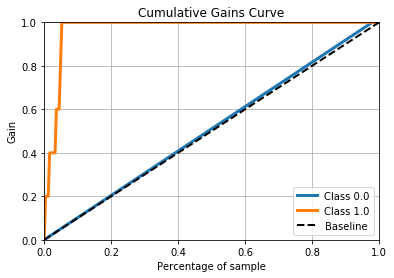

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

#this lift chart shows how the model performs compared to the actual results of the HoF election

### Roc Curve

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
ROC is a probability curve and AUC represents degree or measure of separability. 
It tells how much model is capable of distinguishing between classes. 
Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

Train/Test split results:
LogisticRegression accuracy is 0.988
LogisticRegression log_loss is 0.112
LogisticRegression auc is 0.850


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


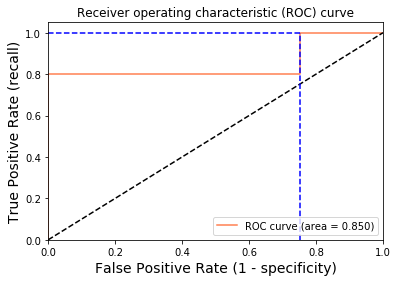

Using a threshold of 0.000 guarantees a sensitivity of 1.000 and a specificity of 0.248, i.e. a false positive rate of 75.21%.


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss


# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Text(0.5, 257.44, 'Predicted label')

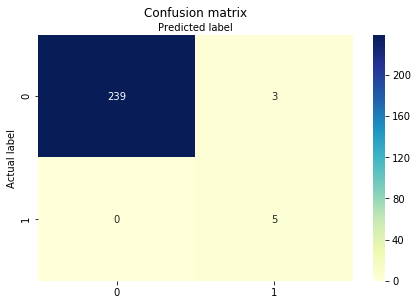

In [17]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Use the describe() function to see what the 25th percentile is for a set of stats. This will be our 'threshold' to make the HoF (a player should reach the threshold in order to have a good change of making the HoF

Change the data type to conduct describe analysis

In [18]:
#tranforming the inducted column in each df to factor so only two colors are shown on specific plots
X['inducted'] = X['inducted'].astype(object)

In [19]:
dfC[dfC['inducted'] == 1][['awardCount', 'RC']].describe()

,awardCount,RC
count,14.000000,14.000000
mean,14.642857,1069.857143
std,9.459282,287.588075
min,0.000000,559.000000
25%,6.250000,856.750000
50%,14.500000,1157.000000
75%,21.500000,1257.500000
max,29.000000,1479.000000


A player must win at least 6.25 awards and create at least 856.75 runs to have a good chance of making HoF

#### Using 25th percentile for minimum HoF worthy statistics

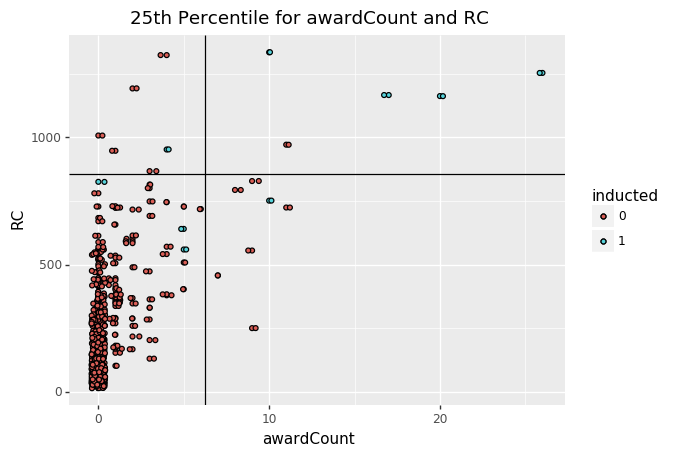

<ggplot: (-9223363247366716181)>

In [20]:
X['inducted'] = X['inducted'].astype(object)
ggplot(X, aes(x = 'awardCount', y = 'RC', fill='inducted'))  \
+ geom_vline(xintercept=6.25) + geom_hline(yintercept=856.75)  + geom_point() + geom_jitter() + ggtitle("25th Percentile for awardCount and RC")
#outline steroids in yellow


#use different dataframes to show viz's for each ()



In [21]:
results = sm.Logit(y_train, X_train).fit(method = 'nm', maxiter=1000)

# print(results.summary())
# print("--"*50)
# print('Confidence Interval:')
# results.conf_int()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Coefficients Plot

This will show variable coeffieicients for each variable in our dfP model.The coefficient value represents the mean change in the response given a one-unit increase in the predictor. Consequently, it's easy to think that variables with larger coefficients are more important because they represent a larger change in the response.

In [22]:
err_series = results.params - results.conf_int()[0]

coef_df = pd.DataFrame({'coef': (results.params.values),
                        'err': (err_series.values),
                        'varname': err_series.index.values
                       })

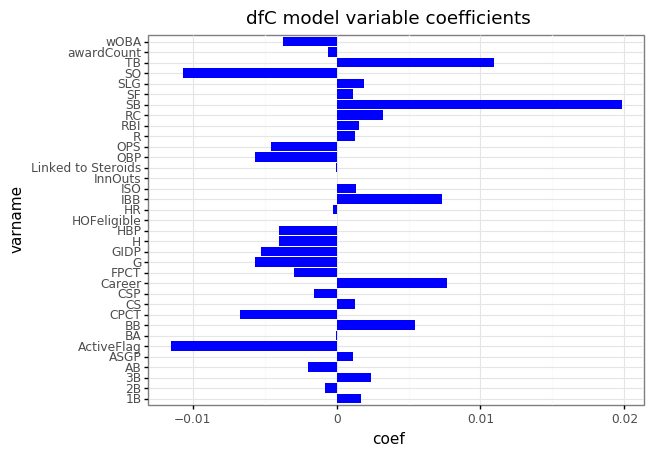

<ggplot: (8789440664107)>

In [23]:
g1 = ggplot(coef_df, aes(x='varname', y='coef')) +  geom_bar(stat="identity", fill='blue', position=position_dodge(width=0.9),width=0.9) 
g1 = g1 +  coord_flip() + theme_bw() + labs(title='dfC model variable coefficients')
g1 

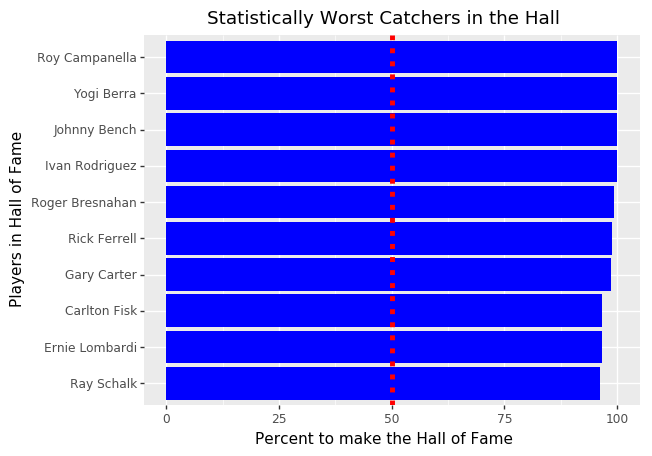

<ggplot: (-9223363247414158746)>

In [24]:
bot_dfC = dfC[dfC.inducted == 1].sort_values(by='hof_perc', ascending=True).head(10)
bot_dfC_list = bot_dfC.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
bot_dfC_list
bot_dfc_cat = pd.CategoricalDtype(categories=bot_dfC_list, ordered=True)
bot_dfC['name_cat'] = bot_dfC['fullName'].astype(str).astype(bot_dfc_cat)

g1 = ggplot(bot_dfC, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g1 = g1 + ylab("Percent to make the Hall of Fame") + xlab("Players in Hall of Fame")
g1 = g1 + ggtitle("Statistically Worst Catchers in the Hall")
g1 + geom_hline(yintercept = 50, linetype="dotted", color="red",size = 2)



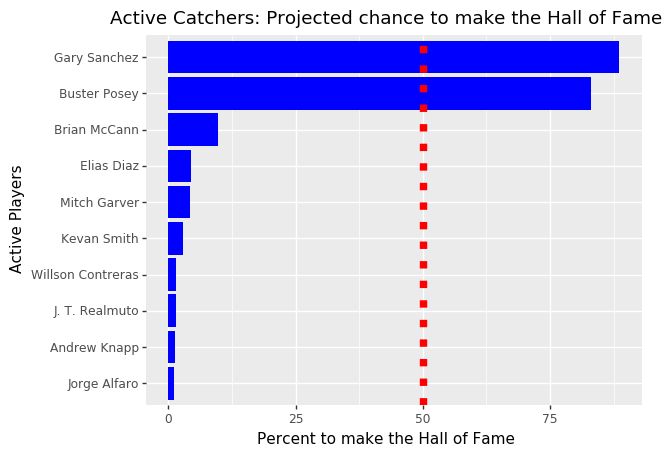

<ggplot: (-9223363247414105705)>

In [25]:

People = pd.read_csv('~/jupyter/cs2019_Group4/data/core/People.csv')
People = People.drop(['birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState','birthCity','deathYear','deathMonth'], axis=1)
People = People.drop(['deathDay', 'deathCountry', 'deathState', 'deathCity', 'weight','height','bats','throws'], axis=1)
People = People.drop(['retroID', 'bbrefID'], axis=1)
People = People.drop(['nameFirst', 'nameLast', 'nameGiven','debut'], axis=1)
People['finalGame']= pd.to_datetime(People['finalGame'])
People['ActiveFlag'] = np.where((People['finalGame'].dt.year==datetime.datetime.now().year), 1, 0)#making boolean flag to indicate if a player is still playing
People = People[People['ActiveFlag'] ==1]
People.head()
dfCvisactive= People.merge(dfC, on='playerID', how='inner')
dfCvisactive.to_csv('dfCvalidator', index=False)
act_dfC = dfCvisactive.sort_values(by='hof_perc', ascending=False).head(10)
act_dfC_list = act_dfC.sort_values(by='hof_perc', ascending=True)['fullName'].tolist()
act_dfC_list
act_dfC_cat = pd.CategoricalDtype(categories=act_dfC_list, ordered=True)
act_dfC['name_cat'] = act_dfC['fullName'].astype(str).astype(act_dfC_cat)

g2 = ggplot(act_dfC, aes(x='name_cat', y='hof_perc'))  + geom_bar(stat='identity', fill='blue') + coord_flip()
g2 = g2 + ylab("Percent to make the Hall of Fame") + xlab("Active Players")
g2 = g2 + ggtitle("Active Catchers: Projected chance to make the Hall of Fame")
g2 + geom_hline(yintercept = 50, linetype="dotted", color="red",size = 3)

